**Deep RL + Continuous State**  
**Task**  
 Implement a **DQN (Deep Q-Network)** agent that processes **continuous inputs**:  
 - **`gaze_ratio`**: Float (0.0 to 1.0).  
- **`tone_score`**: Float (-1.0 to +1.0, from sentiment analysis).  

**Action Space**  
 - **`discount_percent`**: 0%, 5%, or 10%.  

 **Reward Function**  
 - **`+10`** if purchase, **`-2 * discount_percent`** if no purchase.  

**Deliverables - source code**  
 1. **Preprocess states** (normalize gaze/tone).  
 2. **Implement DQN** with a 2-layer neural network.  
 3. **Train for 50 episodes** and plot rewards over time.  


In [4]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from collections import deque

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


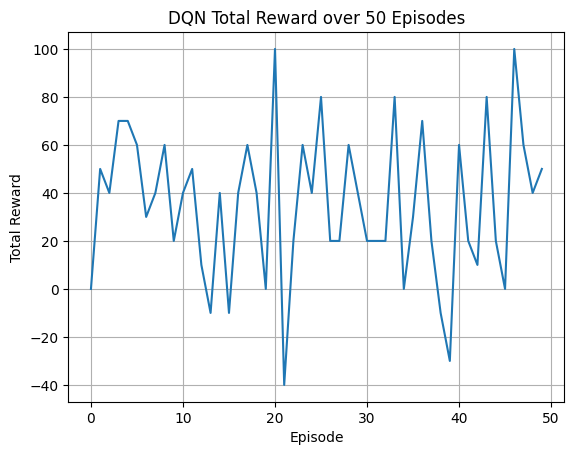

In [5]:

# Reward simulator
def simulate_response(state, discount_percent):
    gaze_ratio, tone_score = state
    prob = 0.2 + 0.5 * gaze_ratio + 0.2 * (tone_score + 1) + 0.1 * (discount_percent / 10)
    return 10 if np.random.rand() < prob else -2 * discount_percent

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.discount_levels = [0, 5, 10]
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.batch_size = 32

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu', input_shape=(self.state_dim,)),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(self.action_dim)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return random.choice(self.discount_levels)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return self.discount_levels[np.argmax(q_values[0])]

    def remember(self, state, action, reward, next_state):
        action_idx = self.discount_levels.index(action)
        self.memory.append((state, action_idx, reward, next_state))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, targets = [], []
        for state, action_idx, reward, next_state in minibatch:
            target = self.model.predict(state[np.newaxis], verbose=0)[0]
            next_q = np.amax(self.target_model.predict(next_state[np.newaxis], verbose=0)[0])
            target[action_idx] = reward + self.gamma * next_q
            states.append(state)
            targets.append(target)
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

# Training
agent = DQNAgent(state_dim=2, action_dim=3)
rewards_per_episode = []

for episode in range(50):
    total_reward = 0
    for _ in range(10):
        state = np.array([np.random.random(), np.random.uniform(-1, 1)])
        action = agent.act(state)
        reward = simulate_response(state, action)
        next_state = np.array([np.random.random(), np.random.uniform(-1, 1)])
        agent.remember(state, action, reward, next_state)
        agent.train()
        total_reward += reward
    rewards_per_episode.append(total_reward)
    agent.update_target_model()

# Plot
plt.plot(rewards_per_episode)
plt.title("DQN Total Reward over 50 Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

## **Ethical RL for Dynamic Pricing**  
### **Task**  
Your team built an RL agent that **maximizes profit** by offering personalized discounts. It works but:  
- **Exploits** impatient shoppers (e.g., charges more if they seem hurried).  
- **Ignores** long-term brand trust.  

### **Deliverables - a doc file**  
1. **Identify 2 ethical risks** (e.g., discrimination, dark patterns).  
2. **Reframe the reward function** to balance profit and fairness.  
3. **Propose a modular "ethics layer"** (e.g., a fairness checker block).  

## Ethical Considerations in Reinforcement Learning for Dynamic Pricing

### 1. Ethical Risks

#### a. Discrimination via Proxy Features

The RL model may inadvertently discriminate against certain demographics by using proxy variables such as zip code, device type, or time of access. For example, users in specific geographic regions or using older devices may consistently receive fewer discounts, reinforcing socio-economic disparities.

#### b. Use of Dark Patterns

By identifying behavioral traits such as urgency or indecision, the agent might use this to increase prices, leveraging psychological pressure to drive purchases. This practice manipulates users rather than serving them, potentially eroding trust and leading to reputational harm.

#### c. Lack of Informed Consent
Users often don’t know they’re subject to algorithmically determined, personalized pricing. Without clear consent or disclosure, they cannot make informed decisions. This violates principles of transparency and autonomy.

### 2. Reframed Reward Function

To encourage ethical behavior, we propose the following composite reward:

```
reward = profit_gain - alpha * unfairness_penalty + beta * trust_bonus
```

* `profit_gain`: Monetary reward from a transaction.
* `unfairness_penalty`: A calculated penalty based on deviations from fairness metrics (e.g., demographic parity).
* `trust_bonus`: A bonus score representing engagement longevity, return frequency, or NPS (Net Promoter Score).
* `alpha` and `beta`: Tunable weights to balance short-term profit with long-term fairness and brand trust.

This encourages the RL agent to favor strategies that both generate revenue and treat users equitably over time.

### 3. Proposed Modular Ethics Layer

We recommend integrating an "Ethics Layer" into the RL pipeline that includes the following components:

#### a. Fairness Checker

* **Input**: State-action pairs
* **Output**: Fairness score (e.g., using disparate impact ratio, equality of opportunity)
* **Action**: Penalize or block actions that cross predefined ethical thresholds

#### b. Transparency Module

* **Logs**: Maintain human-readable logs of pricing decisions, including features used and rationale.
* **Audit**: Allow external audit for regulatory compliance.

#### c. Override Mechanism

* **Policy Interceptor**: In high-risk situations (e.g., user shows signs of vulnerability), override the RL agent's action with a policy-compliant fallback.

By embedding these modules into the training and deployment phases, we create a safer, more responsible pricing agent that aligns with both organizational goals and societal expectations.
